Using device: cuda
Classes: ['blackheads', 'cysts', 'nodules', 'papules', 'pustules', 'whiteheads']


Epoch 1/15: 100%|██████████| 59/59 [00:08<00:00,  7.34it/s, loss=1.69]



Epoch 1 | Loss: 1.7995 | Val Acc: 0.2259
Best model saved.


Epoch 2/15: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s, loss=1.78]



Epoch 2 | Loss: 1.7726 | Val Acc: 0.2929
Best model saved.


Epoch 3/15: 100%|██████████| 59/59 [00:06<00:00,  8.61it/s, loss=1.74]



Epoch 3 | Loss: 1.7435 | Val Acc: 0.3264
Best model saved.


Epoch 4/15: 100%|██████████| 59/59 [00:07<00:00,  8.41it/s, loss=1.67]



Epoch 4 | Loss: 1.7166 | Val Acc: 0.3640
Best model saved.


Epoch 5/15: 100%|██████████| 59/59 [00:06<00:00,  8.62it/s, loss=1.8] 



Epoch 5 | Loss: 1.6942 | Val Acc: 0.3849
Best model saved.
Unfreezing entire network...


Epoch 6/15: 100%|██████████| 59/59 [00:14<00:00,  4.20it/s, loss=1]   



Epoch 6 | Loss: 1.4031 | Val Acc: 0.5858
Best model saved.


Epoch 7/15: 100%|██████████| 59/59 [00:13<00:00,  4.37it/s, loss=1.05] 



Epoch 7 | Loss: 0.6878 | Val Acc: 0.7448
Best model saved.


Epoch 8/15: 100%|██████████| 59/59 [00:13<00:00,  4.42it/s, loss=0.184] 



Epoch 8 | Loss: 0.2345 | Val Acc: 0.7615
Best model saved.


Epoch 9/15: 100%|██████████| 59/59 [00:14<00:00,  4.21it/s, loss=0.173] 



Epoch 9 | Loss: 0.0941 | Val Acc: 0.7824
Best model saved.


Epoch 10/15: 100%|██████████| 59/59 [00:15<00:00,  3.88it/s, loss=0.043] 



Epoch 10 | Loss: 0.0367 | Val Acc: 0.7866
Best model saved.


Epoch 11/15: 100%|██████████| 59/59 [00:15<00:00,  3.83it/s, loss=0.105] 



Epoch 11 | Loss: 0.0282 | Val Acc: 0.7782


Epoch 12/15: 100%|██████████| 59/59 [00:15<00:00,  3.69it/s, loss=0.0134] 



Epoch 12 | Loss: 0.0184 | Val Acc: 0.7824


Epoch 13/15: 100%|██████████| 59/59 [00:15<00:00,  3.86it/s, loss=0.00612]



Epoch 13 | Loss: 0.0146 | Val Acc: 0.7824


Epoch 14/15: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s, loss=0.0689] 



Epoch 14 | Loss: 0.0131 | Val Acc: 0.7908
Best model saved.


Epoch 15/15: 100%|██████████| 59/59 [00:14<00:00,  3.97it/s, loss=0.0465] 



Epoch 15 | Loss: 0.0105 | Val Acc: 0.7657
Training Complete. Best Val Acc: 0.7907949790794979

Classification Report:
              precision    recall  f1-score   support

  blackheads       0.46      0.60      0.52        96
       cysts       0.42      0.47      0.44       100
     nodules       0.36      0.33      0.34        94
     papules       0.28      0.22      0.25        95
    pustules       0.63      0.51      0.56        97
  whiteheads       0.29      0.31      0.30        98

    accuracy                           0.41       580
   macro avg       0.41      0.41      0.40       580
weighted avg       0.41      0.41      0.40       580



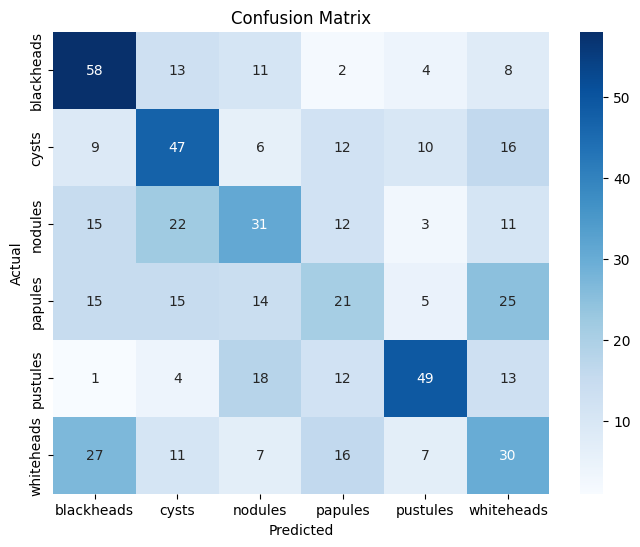

In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report


def main():

    DATA_DIR = "D:/AI-Powered-Skin-Facial-Condition-Diagnosis-Mobile-Application-main/server/dataset"
    MODEL_DIR = "../models"
    BATCH_SIZE = 32
    NUM_EPOCHS = 15
    FREEZE_EPOCHS = 5
    LR = 3e-5

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", DEVICE)

    os.makedirs(MODEL_DIR, exist_ok=True)

    # =====================
    # Transforms (No augmentation here)
    # =====================
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
    valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "valid"), transform=transform)
    test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    class_names = train_dataset.classes
    num_classes = len(class_names)
    print("Classes:", class_names)

    # Save class mapping
    with open(os.path.join(MODEL_DIR, "dataset_model_classes.json"), "w") as f:
        json.dump({i: name for i, name in enumerate(class_names)}, f)

    # =====================
    # Model
    # =====================
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(DEVICE)

    # Freeze backbone
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    # Class weights
    class_counts = np.bincount(train_dataset.targets)
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
    scaler = torch.cuda.amp.GradScaler()

    best_val_acc = 0.0

    # =====================
    # Training Loop
    # =====================
    for epoch in range(NUM_EPOCHS):

        # Unfreeze after FREEZE_EPOCHS
        if epoch == FREEZE_EPOCHS:
            print("Unfreezing entire network...")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=LR)

        model.train()
        running_loss = 0.0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

        for images, labels in train_bar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_acc = correct / total

        print(f"\nEpoch {epoch+1} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_resnet50.pt"))
            print("Best model saved.")

    print("Training Complete. Best Val Acc:", best_val_acc)

    # =====================
    # Final Test Evaluation
    # =====================
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_resnet50.pt")))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


if __name__ == "__main__":
    main()
